# Introducción

[Clutch](https://clutch.co/) es un sitio B2B (Negocio a negocio, del inglés business-to-business o B2B) de calificaciones y reseñas de empresas tecnológicas. Aquí, éstas son evaluadas en función de una serie de factores cuantitativos y cualitativos entre las que se encuentran reseñas certificadas que realizan sus cliente. Permite constituir una reputación a través de revisiones verificadas de terceros.

No solo es relevante como punto de consulta de información valiosa para la ponderación de proveedores; sino también, como se pretende en el presente, hacer un análisis de la presencia de la competencia en el mercado para establecer puntos de comparación.

# Objetivo

Con este desarrollo se aspira a extraer referencias allí expuesta para constituir una radiografía del mercado. La intensión es simplificar la información en un cuadrante de posicionamiento que permita una rápida comparativa de las empresas que operan en un mismo área (delimitada por rubro y geografía).

La principales técnicas a utilizar son: Web Scraping para recopilar información de forma automática expuesta en Internet, y Text Mining para preprocesar los datos no estructurados obtenidos del portal citado.

# Alcance

El entregable que resulta de este trabajo supone:

- Una pieza de código automatizable que extraiga el texto tal como se expone en el sitio web.
- Preprocesamiento de los registros utilizando técnicas de Text Mining para obtener un set de datos estructurados.
- Reconocer las entidades relevantes de cada lectura para disponer el resultado en forma adecuada para la construcción el resumen pretendido. 

# Consideraciones (a completar)

describir los aspectos a tener en cuenta cuando se hace scraping: CAPTCHA, contenido dinámico, etc.

# Resto de tareas (a completar) 

Cron en hosting
Monitoreo: agente externo para ver si anda -> si anda, me autochequeo
Resolver la caida de internet -> por ejemplo, reintentando
Resolver errores html (40, 50)
Chequear que la estructura cambio o no
Describir cómo construir el dashboard sin construir nada
...

# Futuras lineas de trabajo (a completar)

Extender el origen de información a otros sitios que brinde un servicio de idénticas características.

# Desarrollo

In [55]:
import requests
import pandas as pd

from re import sub
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from typing import Iterable, Union

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Categorías

In [4]:
categories = ['app-developers', 'web-developers', 'developers']

## Utilidades

In [5]:
def get_search_page(category: str, page_number: int) -> BeautifulSoup:
  clutch_argentina = requests.get(f'https://clutch.co/ar/{category}?page={page_number}')
  return BeautifulSoup(clutch_argentina.text)

def get_company_profile(profile_link: str) -> BeautifulSoup:
  profile = requests.get(f'https://clutch.co/{profile_link}')
  return BeautifulSoup(profile.text)

def is_last_page(beautiful_soup_page: BeautifulSoup) -> bool:
  return not beautiful_soup_page.select('li.page-item.last > a')

def get_element_text_if_exists(elements: Iterable) -> Union[str, None]:
  if elements is not None and len(elements) > 0:
    return elements[0].text.strip()

def snake_case(value: str) -> str:
  return '_'.join(sub('[^0-9a-zA-Z\s\_]+', '', value).split()).lower()

In [6]:
def create_row(provider_li: BeautifulSoup) -> dict:
    row = {}
    
    company_info = provider_li.select('h3.company_info a')
    row['company_name'] = get_element_text_if_exists(company_info)
    row['rating'] = get_element_text_if_exists(provider_li.select('.rating'))
    row['reviews'] = get_element_text_if_exists(provider_li.select('.reviews-link'))

    #Min. project size, Avg. hourly rate, Employees, Location
    items = provider_li.select('.module-list > div')
    for item in items:
      key_name = BeautifulSoup(item.attrs['data-content']).text
      row[key_name] = get_element_text_if_exists(item.select('span'))

    #Service Focus
    percentages = provider_li.select('.chartAreaContainer > div')
    for percentage in percentages:
      content = BeautifulSoup(percentage.attrs['data-content'])
      row[f'service_focus_{content.b.text}'] = content.i.text

    #Client focus
    profile_link = provider_li.select('li.website-profile > a')[0].attrs['href']
    profile = get_company_profile(profile_link)
    client_focus = profile.find("div", string='Client focus')

    if client_focus:
      for client in client_focus.find_next_sibling().select('div.grid.custom_popover'):
        key_name = BeautifulSoup(client.attrs['data-content']).b.text
        row[f'client_focus_{key_name}'] = client.text
      
    return row

In [7]:
#search_page = get_search_page('developers', 0)
#search_page

In [8]:
#test_row = create_row(search_page.select('ul.directory-list li.provider-row')[0])
#test_row

## Scraping

In [9]:
def get_companies(category: str) -> pd.DataFrame:
  page_number = 0
  rows = []

  with tqdm() as pbar:
    pbar.set_description(f"Categoria: {category}")

    while True:
      pbar.update(1)

      page = get_search_page(category, page_number)
      company_list = page.select('ul.directory-list li.provider-row')
      rows += [create_row(company) for company in company_list]
      page_number += 1

      if is_last_page(page):
        break
    
  return pd.DataFrame(rows)

In [10]:
# borrar, es para que tarde menos la prueba
# categories = ['app-developers']

companies = []
for category in categories:
    companies.append(get_companies(category))

companies = pd.concat(companies)
#companies.head()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,company_name,rating,reviews,Min. project size,Avg. hourly rate,Employees,Location,service_focus_Mobile App Development,service_focus_Custom Software Development,service_focus_Web Development,client_focus_Midmarket ($10M - $1B),client_focus_Enterprise (>$1B),client_focus_Small Business (,service_focus_Artificial Intelligence,service_focus_IT Staff Augmentation,service_focus_IT Strategy Consulting,service_focus_BI & Big Data Consulting & SI,service_focus_Blockchain,service_focus_Cloud Consulting & SI,service_focus_Application Testing,service_focus_Architectural Design,service_focus_UX/UI Design,service_focus_ERP Consulting and SI,service_focus_E-Commerce Development,service_focus_IoT Development,service_focus_Enterprise App Modernization,service_focus_AR/VR Development,service_focus_CRM Consulting and SI,service_focus_Other,service_focus_Content Marketing,service_focus_Digital Strategy,service_focus_Social Media Marketing,service_focus_Web Design,service_focus_IT Managed Services,service_focus_Other IT Consulting and SI,service_focus_Application Management & Support,service_focus_Product Design,service_focus_Other Application Development,service_focus_Search Engine Optimization,service_focus_Graphic Design,service_focus_HR Services,service_focus_Wearable App Development,service_focus_Branding,service_focus_Email Marketing,service_focus_Advertising,service_focus_Logo,service_focus_Video Production,service_focus_Market Research,service_focus_Pay Per Click,service_focus_Cybersecurity,service_focus_Accounting,service_focus_Business Consulting,service_focus_Translation,service_focus_Other Design,service_focus_Other Digital Marketing,service_focus_Mobile & App Marketing,service_focus_Sales Outsourcing,service_focus_Media Planning & Buying,service_focus_Back Office Outsourcing,service_focus_Conversion Optimization,service_focus_Corporate Training,service_focus_Marketing Strategy,service_focus_Public Relations,service_focus_Corporate Photography,service_focus_Packaging Design,service_focus_Print Design,service_focus_Call Center Services,service_focus_Customer Service Outsourcing,service_focus_Ocean Freight,service_focus_Logistics & Supply Chain Consulting,service_focus_Trucking,service_focus_Air Freight,service_focus_Freight forwarding,service_focus_Customs brokerage,"service_focus_Commercial Financing, Funding, & Investment",service_focus_Unified Communications Consulting & SI
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40%,30%,30%,80%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flux IT,4.9,10 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,NaN,30%,NaN,30%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Azumo,4.9,10 reviews,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",10%,20%,20%,40%,30%,30%,20%,NaN,NaN,10%,10%,10%,NaN,NaN,

### Nombre de columnas

In [11]:
companies.columns = map(snake_case, companies.columns)

In [ ]:
# test
# print(get_companies('web-developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/web-developers').text).select('.tabs-info')[0].text)

# print(get_companies('app-developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/app-developers').text).select('.tabs-info')[0].text)

# print(get_companies('developers').shape)
# print(BeautifulSoup(requests.get(f'https://clutch.co/ar/developers').text).select('.tabs-info')[0].text)

### Algunos Datos

In [12]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business,service_focus_artificial_intelligence,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_iot_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_other,service_focus_content_marketing,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_web_design,service_focus_it_managed_services,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_branding,service_focus_email_marketing,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40%,30%,30%,80%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flux IT,4.9,10 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,NaN,30%,NaN,30%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Azumo,4.9,10 reviews,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",10%,20%,20%,40%,30%,30%,20%,NaN,NaN,10%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Preproceso

### Duplicados

In [14]:
companies = companies.drop_duplicates()

### Valores N/A

In [16]:
companies = companies.fillna('0')

In [17]:
companies.to_csv('clutch_ar_companies.csv', index=False)

# Hoy en clase 21/4/22

In [22]:
companies = pd.read_csv('clutch_ar_companies.csv')

In [47]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business,service_focus_artificial_intelligence,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_iot_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_other,service_focus_content_marketing,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_web_design,service_focus_it_managed_services,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_branding,service_focus_email_marketing,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40,30,30,80,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rootstrap,4.8,34,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25,10,40,40,25,35,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Flux IT,4.9,10,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30,40,30,50,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Clarika,4.8,14,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20,30,10,70,0,30,0,30,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Azumo,4.9,10,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",10,20,20,40,30,30,20,0,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
columns = ['company_name','rating', 'reviews', 'min_project_size', 'avg_hourly_rate', 'employees', 'location']

columns_porcetajes = companies.columns.difference(columns)

In [40]:
for column in columns_porcetajes:
  companies[column] = companies[column].str.replace('%', '')
  companies[column] = companies[column].astype(int)

In [43]:
companies['reviews'] = companies.reviews.str.replace('[reviews|review]', '').astype(int)

<ipython-input-43-66b55f978554>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  companies['reviews'] = companies.reviews.str.replace('[reviews|review]', '').astype(int)


In [53]:
services = (companies[columns_porcetajes] != 0).astype(int).sum()

In [57]:
companies.shape

(538, 76)

In [63]:
columnas_procentaje_principales = ((services.sort_values() / companies.shape[0]) >= 0.1).reset_index()
columnas_procentaje_principales.columns = ['column', 'incluir']

In [66]:
columnas_a_incluir = columnas_procentaje_principales.query('incluir == True').column.tolist()

In [69]:
companies = companies[columns + columnas_a_incluir]

companies.head()


,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [89]:
companies.employees.unique()

array([   29,   149,   624, 10000,     5,  5499,     1])

In [72]:
companies['employees'] = companies.employees.str.replace('Freelancer', '1')

<ipython-input-72-b0bf480eebbe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['employees'] = companies.employees.str.replace('Freelancer', '1')


In [103]:
def calcular_punto_medio(value : str):
    value = value.replace('+', '').replace(',', '')
    values =  [int(v) for v in value.split(' - ')]
    return int(sum(values) / len(values))

In [88]:
companies['employees'] = companies.employees.apply(calcular_punto_medio)

<ipython-input-88-ac4ac51034e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['employees'] = companies.employees.apply(calcular_employees)


In [90]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,"$10,000+",$25 - $49 / hr,29,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,"$50,000+",$100 - $149 / hr,149,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,"$10,000+",Undisclosed,149,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,"$10,000+",$25 - $49 / hr,149,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,"$25,000+",$25 - $49 / hr,149,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [95]:
companies.min_project_size.unique()

array([ 10000,  50000,  25000,   5000,  75000,     -1,   1000, 250000,
       100000])

In [93]:
companies['min_project_size'] = companies.min_project_size.str.replace('Undisclosed', '-1')
companies['min_project_size'] = companies.min_project_size.str.replace('$', '')
companies['min_project_size'] = companies.min_project_size.str.replace(',', '')
companies['min_project_size'] = companies.min_project_size.str.replace('+', '')
companies['min_project_size'] = companies.min_project_size.astype(int)

<ipython-input-93-c593faa74012>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['min_project_size'] = companies.min_project_size.str.replace('Undisclosed', '-1')
<ipython-input-93-c593faa74012>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  companies['min_project_size'] = companies.min_project_size.str.replace('$', '')
<ipython-input-93-c593faa74012>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [94]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,10000,$25 - $49 / hr,29,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,50000,$100 - $149 / hr,149,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,10000,Undisclosed,149,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,10000,$25 - $49 / hr,149,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,25000,$25 - $49 / hr,149,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [105]:
companies.avg_hourly_rate.unique()

array([ 37, 124,  -1,  74,  25, 174])

In [104]:
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('Undisclosed', '-1')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace(' / hr', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('< ', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('$', '')

companies['avg_hourly_rate']  = companies.avg_hourly_rate.apply(calcular_punto_medio)

<ipython-input-104-4fb61e9ca863>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('Undisclosed', '-1')
<ipython-input-104-4fb61e9ca863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace(' / hr', '')
<ipython-input-104-4fb61e9ca863>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [106]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,10000,37,29,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,50000,124,149,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,10000,-1,149,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,10000,37,149,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,25000,37,149,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [110]:
companies.query('rating == 0').shape

(398, 22)

In [111]:
companies.query('(rating == 0) & (reviews == 0)').shape

(398, 22)

## 31/03/22 En clase

In [ ]:
clutch_argentina = requests.get(f'https://clutch.co/ar/developers?page=0')
bs_clutch = BeautifulSoup(clutch_argentina.text)

ultima_pagina = bs_clutch.select('li.page-item.last > a')[0].attrs['data-page']

current_page = bs_clutch.select('li.page-item.active > a')[0].attrs['data-page']

print(ultima_pagina, current_page)

6 0


In [ ]:
def get_element_if_exists(elements):
  if len(elements) > 0:
    return elements[0].text.strip()

In [ ]:
empresas = []

for page_number in range(int(ultima_pagina) + 1):
  clutch_argentina = requests.get(f'https://clutch.co/ar/developers?page={page_number}')
  bs_clutch = BeautifulSoup(clutch_argentina.text)  
  li = bs_clutch.select('ul.directory-list li.provider-row')

  for l in li:
    d = {}
    d['nombre'] = get_element_if_exists(l.select('h3.company_info a'))
    d['rating'] = get_element_if_exists(l.select('.rating'))
    d['reviews'] = get_element_if_exists(l.select('.reviews-link'))

    items = l.select('.module-list > div')
    for i in items:
      key_name = BeautifulSoup(i.attrs['data-content']).text
      d[key_name] = get_element_if_exists(i.select('span'))

    perc = l.select('.chartAreaContainer > div')
    for p in perc:
      contenido = BeautifulSoup(p.attrs['data-content'])
      d[contenido.b.text] = contenido.i.text
      
    empresas.append(d)

In [ ]:
resultado = pd.DataFrame(empresas)
resultado.shape

(328, 64)

In [ ]:
resultado.head()

,nombre,rating,reviews,Min. project size,Avg. hourly rate,Employees,Location,Custom Software Development,IT Staff Augmentation,Mobile App Development,...,Logo,Video Production,Pay Per Click,Customs brokerage,Other Design,Advertising,"Commercial Financing, Funding, & Investment",Translation,Other Digital Marketing,Unified Communications Consulting & SI
0,BEON Tech Studio,4.9,26.0,"$50,000+",$25 - $49 / hr,50 - 249,"Buenos Aires, Argentina",50%,50%,0,...,0,0,0,0,0,0,0,0,0,0
1,Clarika,4.8,13.0,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",30%,30%,20%,...,0,0,0,0,0,0,0,0,0,0
2,Crombie,4.8,15.0,"$10,000+",$25 - $49 / hr,10 - 49,"FQC, Argentina",25%,25%,20%,...,0,0,0,0,0,0,0,0,0,0
3,Patagonian,4.9,6.0,"$75,000+",$50 - $99 / hr,50 - 249,"General Roca, Argentina",20%,0,20%,...,0,0,0,0,0,0,0,0,0,0
4,Rootstrap,4.8,34.0,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",10%,0,25%,...,0,0,0,0,0,0,0,0,0,0


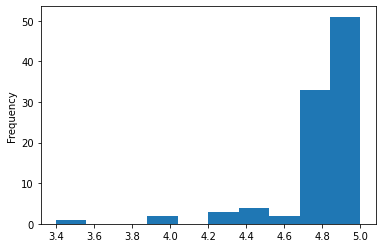

In [ ]:
resultado.rating.astype(float).plot.hist()

In [ ]:
resultado = resultado.fillna('0')
resultado.reviews = resultado.reviews.str.split(' ').str[0]
resultado.reviews = resultado.reviews.astype(float)
resultado.rating = resultado.rating.astype(float)

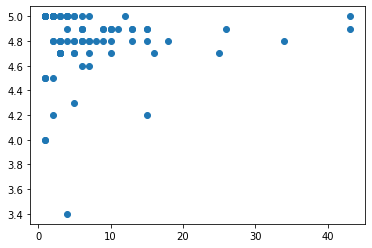

In [ ]:
empresas_con_rating = resultado.query('reviews != 0')
plt.scatter(empresas_con_rating.reviews, empresas_con_rating.rating)

-agregar las categorias: web, software dev(ya esta), mobiel
- eliminar duplicados
- elegir una empresa
- sacar client focus
- filtrar aquellas empresas que al menos dos principales (de mayor porcentaje) de las caracteristicas.
- armar métrica de diferencia: cantidad de empleados maximo y restar la elegida, lo mismo con min project size, mismo tarifa. ¿armamos una sola metrica con las tres o las tres por separadas?
- 
- graficar